### **Reinforcement Learning Concepts for CartPole Balancing**

Before diving into the project implementation, let’s build a strong foundation of the core concepts needed to master **Reinforcement Learning** (RL) and the **CartPole task**.

---

### **1. Reinforcement Learning Fundamentals**

1. **Agent and Environment**:
   - **Agent**: Learns to take actions to maximize reward.
   - **Environment**: Represents the problem (CartPole in our case) and provides feedback (state, reward, done) to the agent.

2. **Markov Decision Process (MDP)**:
   - **State (s)**: Represents the current situation in the environment (e.g., cart position, velocity, pole angle).
   - **Action (a)**: The choice made by the agent (e.g., move left or right).
   - **Reward (r)**: Feedback given after taking an action (e.g., +1 for balancing the pole).
   - **Transition (T)**: How actions move the environment to a new state.
   - Goal: Maximize cumulative reward (return).

3. **Policy (\(\pi\))**:
   - A function that maps states to actions.
   - Can be deterministic (\(a = \pi(s)\)) or stochastic (\(\pi(a|s)\)).

4. **Value Function**:
   - **State Value (\(V(s)\))**: The expected return from a state \(s\).
   - **Action Value (\(Q(s, a)\))**: The expected return from taking action \(a\) in state \(s\).

5. **Exploration vs Exploitation**:
   - **Exploration**: Trying new actions to learn about the environment.
   - **Exploitation**: Using known actions to maximize reward.

---

### **2. CartPole Problem**

1. **Goal**:
   - Balance a pole on a moving cart as long as possible.
   - Avoid the pole falling beyond a certain angle or the cart moving out of bounds.

2. **State Space**:
   - A 4-dimensional vector:
     1. Cart position.
     2. Cart velocity.
     3. Pole angle.
     4. Pole angular velocity.

3. **Action Space**:
   - Discrete: Move the cart left (0) or right (1).

4. **Reward**:
   - +1 for every step the pole remains balanced.

5. **Termination**:
   - The pole angle exceeds ±12 degrees.
   - The cart moves beyond ±2.4 units.
   - Time steps exceed the environment's maximum steps (500 in `CartPole-v1`).

---

### **3. Key RL Algorithms for CartPole**

#### **3.1 Deep Q-Learning (DQN)**
1. **Q-Learning**:
   - Learn the action-value function \(Q(s, a)\), which predicts the future reward of taking action \(a\) in state \(s\).
   - Update Rule:
     \[
     Q(s, a) \leftarrow Q(s, a) + \alpha \left[r + \gamma \max_{a'} Q(s', a') - Q(s, a)\right]
     \]
   - Challenges: Large state-action spaces make storing \(Q(s, a)\) infeasible.

2. **Deep Q-Learning**:
   - Uses a neural network to approximate \(Q(s, a)\).
   - **Experience Replay**: Stores past experiences in a replay buffer to sample and train.
   - **Target Network**: A separate network is used to stabilize the Q-value updates.

3. **Loss Function**:
   \[
   L(\theta) = \mathbb{E}_{s, a, r, s'} \left[ \left(r + \gamma \max_{a'} Q(s', a'; \theta') - Q(s, a; \theta)\right)^2 \right]
   \]

#### **3.2 Policy Gradient**
1. **Policy-Based Methods**:
   - Directly optimize the policy \(\pi(a|s; \theta)\) to maximize cumulative reward.
   - Uses the **REINFORCE** algorithm:
     \[
     \nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \nabla_\theta \log \pi_\theta(a|s) R \right]
     \]
   - \(R\) is the cumulative reward.

2. **Advantages**:
   - Handles continuous action spaces.
   - Can directly learn stochastic policies.

3. **Challenges**:
   - High variance in updates.
   - Requires careful tuning of the learning rate and reward discount factor (\(\gamma\)).

---

### **4. Exploration Strategies**

1. **Epsilon-Greedy**:
   - Select a random action with probability \(\epsilon\).
   - Otherwise, choose the action with the highest predicted reward.

2. **Decaying \(\epsilon\)**:
   - Start with high exploration (\(\epsilon = 1.0\)).
   - Gradually decay \(\epsilon\) to a lower value (e.g., \(\epsilon = 0.01\)) for exploitation.

---

### **5. Evaluation Metrics**

1. **Reward Curve**:
   - Plot total reward per episode to track learning progress.
   - A high reward curve indicates effective learning.

2. **Policy Stability**:
   - Evaluate how consistently the agent balances the pole.

3. **Action Distribution**:
   - Analyze the actions taken by the agent during training.

---

### **6. Practical Challenges**

1. **Reward Sparsity**:
   - Rewards are often sparse, making it harder for the agent to learn.

2. **Overfitting to the Environment**:
   - The agent may learn to exploit quirks of the simulation.

3. **Hyperparameter Tuning**:
   - Important parameters include learning rate, discount factor (\(\gamma\)), batch size, and replay buffer size.








# Import Libraries

In [9]:
import gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Define the DQN Agent

In [15]:
class DQNAgent:
    # state_size: The size of the input state vector (e.g., 4 for CartPole).
    # action_size: The number of possible actions the agent can take (e.g., 2 for CartPole: move left or right).
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        # Stores past experiences (state, action, reward, next_state, done)
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95 # discount factor
        self.epsilon = 1.0 # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64  # Batch size for replay
        # The main neural network to approximate Q-values.
        self.model = self.build_model()
        #  A separate network to stabilize training
        self.target_model = self.build_model()
        #  Copies weights from self.model to self.target_model.
        self.update_target_model()

    # This defines a feedforward neural network for approximating Q(s,a)Q(s,a) (state-action value).
    def build_model(self):
        # neural network for approximate q values
        # Layers: 
        # Input Layer: Size equals state_size.
        # Hidden Layers:
        #     Two fully connected layers (24 neurons each) with ReLU activations.
        #     ReLU introduces non-linearity and prevents vanishing gradients.
        # Output Layer:
        #     Size equals action_size (one output for each possible action).
        # Outputs represent Q-values for each action given the input state.
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size)
        )
        return model.to(device)
    
    # Copies weights from the main model (self.model) to the target model (self.target_model).
    # Helps stabilize training by maintaining a slowly changing target for Q-value updates.
    def update_target_model(self):
        # Update the target network with the weights of the main model
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


    # Implements an epsilon-greedy strategy:

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Random action
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.model(state)
        return torch.argmax(q_values).item()
    
    #Trains the agent by sampling a minibatch of experiences from memory:

    def replay(self):
        # Train the model using a batch of experiences from the replay buffer
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(next_state)).item()
            target_f = self.model(state).detach().clone()
            target_f[0][action] = target
            self.model.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
            optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Train the agent 

In [17]:
env = gym.make('CartPole-v1')  # Load the CartPole environment
state_size = env.observation_space.shape[0]  # State size
action_size = env.action_space.n  # Number of actions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

agent = DQNAgent(state_size, action_size)
num_episodes = 500
target_update = 10  # Update target model every 10 episodes
scores = []

for e in range(num_episodes):
    # Update env.reset() to extract the observation
    state, _ = env.reset()  # Extract only the observation
    state = np.float32(state)  # Ensure state is in float format
    total_reward = 0
    done = False
    
    while not done:
        action = agent.act(state)  # Select an action
        # Update env.step() to handle the new return values
        next_state, reward, done, truncated, _ = env.step(action)  # Extract all necessary components
        done = done or truncated  # Treat 'truncated' as done if applicable
        reward = reward if not done else -10  # Penalize for failure
        next_state = np.float32(next_state)  # Ensure next_state is in float format
        agent.remember(state, action, reward, next_state, done)  # Store experience in memory
        state = next_state
        total_reward += reward

        # Train the agent
        agent.replay()
    
    scores.append(total_reward)
    print(f"Episode {e + 1}/{num_episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")

    # Update the target model periodically
    if e % target_update == 0:
        agent.update_target_model()


/Users/Senjuti/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1/500, Score: 2.0, Epsilon: 1.00
Episode 2/500, Score: 11.0, Epsilon: 1.00
Episode 3/500, Score: 12.0, Epsilon: 1.00
Episode 4/500, Score: 7.0, Epsilon: 0.94
Episode 5/500, Score: 0.0, Epsilon: 0.89
Episode 6/500, Score: 3.0, Epsilon: 0.83
Episode 7/500, Score: 2.0, Epsilon: 0.77
Episode 8/500, Score: 16.0, Epsilon: 0.68
Episode 9/500, Score: 6.0, Epsilon: 0.62
Episode 10/500, Score: 3.0, Epsilon: 0.58
Episode 11/500, Score: 15.0, Epsilon: 0.51
Episode 12/500, Score: 16.0, Epsilon: 0.44
Episode 13/500, Score: 0.0, Epsilon: 0.42
Episode 14/500, Score: 13.0, Epsilon: 0.37
Episode 15/500, Score: 1.0, Epsilon: 0.35
Episode 16/500, Score: 6.0, Epsilon: 0.32
Episode 17/500, Score: 13.0, Epsilon: 0.29
Episode 18/500, Score: 17.0, Epsilon: 0.25
Episode 19/500, Score: 3.0, Epsilon: 0.23
Episode 20/500, Score: 9.0, Epsilon: 0.21
Episode 21/500, Score: 5.0, Epsilon: 0.19
Episode 22/500, Score: 4.0, Epsilon: 0.18
Episode 23/500, Score: 9.0, Epsilon: 0.16
Episode 24/500, Score: 28.0, Epsilo

# Plot results 

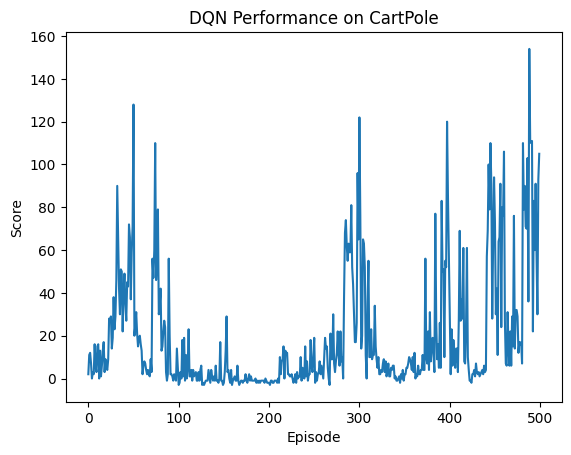

In [18]:
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('DQN Performance on CartPole')
plt.show()


# Testing the DQN Agent 

In [26]:
import gym
import numpy as np
import torch

# Initialize the environment with render_mode
env = gym.make("CartPole-v1", render_mode="human")

# Set the agent to evaluation mode
agent.model.eval()

# Number of episodes for testing
num_test_episodes = 10

# List to store total rewards
total_rewards = []

for episode in range(num_test_episodes):
    # Reset the environment and unpack the observation
    state, _ = env.reset()  # Only take the observation, ignore metadata
    state = np.float32(state)  # Ensure state is float
    total_reward = 0
    done = False

    while not done:
        # Use the learned policy to act (no exploration)
        action = agent.act(state)

        # Take action in the environment
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated  # Combine done and truncated flags

        # Accumulate the reward
        total_reward += reward

        # Update the current state
        state = next_state

    total_rewards.append(total_reward)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

env.close()

# Calculate and display the average reward
average_reward = np.mean(total_rewards)
print(f"Average Reward over {num_test_episodes} episodes: {average_reward:.2f}")


2024-11-25 17:07:22.158 Python[47210:14337197] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.
/Users/Senjuti/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Total Reward = 144.0
Episode 2: Total Reward = 131.0
Episode 3: Total Reward = 123.0
Episode 4: Total Reward = 124.0
Episode 5: Total Reward = 124.0
Episode 6: Total Reward = 133.0
Episode 7: Total Reward = 137.0
Episode 8: Total Reward = 139.0
Episode 9: Total Reward = 134.0
Episode 10: Total Reward = 127.0
Average Reward over 10 episodes: 131.60


# Implementation of policy gradient 

In [27]:
class PolicyGradientAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99  # Discount factor
        self.policy = nn.Sequential(
            nn.Linear(state_size, 24),
            nn.ReLU(),
            nn.Linear(24, action_size),
            nn.Softmax(dim=-1)  # Output probabilities
        )
        self.optimizer = optim.Adam(self.policy.parameters(), lr=0.001)
        self.memory = []  # To store state, action, and rewards

    def remember(self, state, action, reward):
        self.memory.append((state, action, reward))

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)  # Convert state to a tensor and add batch dimension
        probabilities = self.policy(state)
        action = np.random.choice(self.action_size, p=probabilities.detach().numpy().squeeze())
        return action

    def train(self):
        R = 0
        returns = []  # To store discounted returns
        for _, _, reward in reversed(self.memory):
            R = reward + self.gamma * R
            returns.insert(0, R)
        returns = torch.FloatTensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)  # Normalize returns

        self.optimizer.zero_grad()
        loss = 0
        for (state, action, _), Gt in zip(self.memory, returns):
            state = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor
            probabilities = self.policy(state)
            log_prob = torch.log(probabilities.squeeze(0)[action])
            loss -= log_prob * Gt  # Policy gradient loss
        loss.backward()
        self.optimizer.step()
        self.memory = []  # Clear memory after training

# Train the policy gradient agent

In [21]:
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
pg_agent = PolicyGradientAgent(state_size, action_size)

# Training loop
num_episodes = 500
for episode in range(num_episodes):
    state, _ = env.reset()  # Reset the environment (adjust for newer Gym versions)
    state = np.array(state, dtype=np.float32)  # Ensure state is float32
    done = False
    total_reward = 0

    while not done:
        action = pg_agent.act(state)  # Select action
        next_state, reward, done, _, = env.step(action)  # Take action
        next_state = np.array(next_state, dtype=np.float32)  # Ensure next_state is float32
        pg_agent.remember(state, action, reward)  # Store experience
        state = next_state  # Update state
        total_reward += reward

    pg_agent.train()  # Train the policy after each episode
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")



ValueError: expected sequence of length 4 at dim 1 (got 0)